_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [ ]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install matplotlib==3.7.1
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`).

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [ ]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url)

#Convert the 'Date' column to datetime format
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'])

# Set the 'Date' column as the index
df.set_index('Inspection Date', inplace=True)



In [ ]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


**Task 1 Test**

In [ ]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [ ]:
'''T2. Identify data leakage column.'''

leaky_col = str('Serious Violations Found')

#data leakage is defined as features that contain data that would not be accessible in real world predictions, or data that is found to RESULT in the target 'RISK'

#columns that provide leakage are ['Inspection_ID' , 'Inspection_Date' , 'Inspection_Type' , 'Violations' , 'Fail' , 'Serious_Violations_Found']

#duplicate columns are ['Location'] / 'latitude' & 'longitude' are separate features.

**Task 2 Test**

In [ ]:
'''T2 Test'''
# This is a hidden test.
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [ ]:
'''T3. Write wrangle function.'''
def wrangle(df):

     # Remove specific columns


    df.columns = df.columns.str.replace(' ', '_')

    columns_to_remove = ['State' , 'Address' ,'Inspection_ID', 'Serious_Violations_Found', 'License_#' , 'AKA_Name' , 'DBA_Name' , 'Location', 'Violations']  # Replace with the names of the columns you want to remove
    df = df.drop(columns=columns_to_remove)

    return df

df = wrangle(df)

**Task 3 Test**

In [ ]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [ ]:
# cleaning 'City' typecase errors
df['City'] = df['City'].replace('Chicago', 'CHICAGO')
df['City'] = df['City'].replace('chicago', 'CHICAGO')
df['City'] = df['City'].replace('CHicago', 'CHICAGO')
df['City'] = df['City'].replace('CHICAGOI', 'CHICAGO')
df['City'] = df['City'].replace('CHICAGO HEIGHTS', 'CHICAGO')
df['City'] = df['City'].replace('CCHICAGO', 'CHICAGO')
df['City'] = df['City'].replace('CHICAGOCHICAGO', 'CHICAGO')
df['City'] = df['City'].replace('CHICAGOHICAGO', 'CHICAGO')
df['City'] = df['City'].replace('CHCHICAGO', 'CHICAGO')
df['City'] = df['City'].replace('NILES NILES', 'NILES')
df['City'] = df['City'].replace('OOLYMPIA FIELDS', 'OLYMPIA FIELDS')
df['City'] = df['City'].replace('SCHAUMBURG', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('MAYWOOD', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('ELK GROVE VILLAGE', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('CICERO', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('CHESTNUT STREET', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('OAK PARK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('CHARLES A HAYES', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('STREAMWOOD', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('BROADVIEW', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('BERWYN', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('BRIDGEVIEW', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('BEDFORD PARK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('SUMMIT', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('SCHILLER PARK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('TINLEY PARK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('BOLINGBROOK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('HIGHLAND PARK', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('WORTH', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('EVANSTON', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('LAKE BLUFF', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('ALSIP', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('ELMHURST', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('ROSEMONT', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('SKOKIE', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('EAST HAZEL CREST', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('NAPERVILLE', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('NILES', 'CHICAGO SUBURBS')
df['City'] = df['City'].replace('OLYMPIA FIELDS', 'CHICAGO SUBURBS')

In [ ]:
df['City'].fillna("CHICAGO SUBURBS", inplace=True)


In [ ]:
df['Inspection_Type'] = df['Inspection_Type'].replace('CANVASS/SPECIAL EVENT', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('ADDENDUM', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('OUT OF BUSINESS', 'Out of Business')
df['Inspection_Type'] = df['Inspection_Type'].replace('REINSPECTION OF 48 HOUR NOTICE', 'Canvass Re-Inspection')
df['Inspection_Type'] = df['Inspection_Type'].replace('SFP/COMPLAINT', 'Complaint')
df['Inspection_Type'] = df['Inspection_Type'].replace('Complaint-Fire', 'Complaint')
df['Inspection_Type'] = df['Inspection_Type'].replace('Short Form Fire-Complaint', 'Complaint')
df['Inspection_Type'] = df['Inspection_Type'].replace('Complaint-Fire Re-inspection', 'Complaint Re-Inspection')
df['Inspection_Type'] = df['Inspection_Type'].replace('Suspected Food Poisoning Re-inspection', 'Suspected Food Poisoning')
df['Inspection_Type'] = df['Inspection_Type'].replace('LICENSE REQUEST', 'License')
df['Inspection_Type'] = df['Inspection_Type'].replace('license', 'License')
df['Inspection_Type'] = df['Inspection_Type'].replace('LICENSE DAYCARE 1586', 'License')
df['Inspection_Type'] = df['Inspection_Type'].replace('SFP/Complaint', 'Suspected Food Poisoning')
df['Inspection_Type'] = df['Inspection_Type'].replace('License-Task Force', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('SPECIAL TASK FORCE', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('POSSIBLE FBI', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('License consultation', 'Consultation')
df['Inspection_Type'] = df['Inspection_Type'].replace('KIDS CAFE', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('RECALL INSPECTION', 'Canvass Re-Inspection')
df['Inspection_Type'] = df['Inspection_Type'].replace('LICENSE WRONG ADDRESS', 'License')
df['Inspection_Type'] = df['Inspection_Type'].replace('SMOKING COMPLAINT', 'Complaint')
df['Inspection_Type'] = df['Inspection_Type'].replace('CLOSE-UP/COMPLAINT REINSPECTION', 'Complaint Re-Inspection')
df['Inspection_Type'] = df['Inspection_Type'].replace('TWO PEOPLE ATE AND GOT SICK.', 'Suspected Food Poisoning')
df['Inspection_Type'] = df['Inspection_Type'].replace('TAVERN 1470', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('TASK FORCE LIQUOR 1470', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('TASK FORCE LIQUOR (1481)', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('Task Force Liquor 1475', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('Package Liquor 1474', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('Tag Removal', 'Consultation')
df['Inspection_Type'] = df['Inspection_Type'].replace('Out of Business', 'No Entry')
df['Inspection_Type'] = df['Inspection_Type'].replace('CHANGED COURT DATE', 'No Entry')
df['Inspection_Type'] = df['Inspection_Type'].replace('CANVASS SPECIAL EVENTS', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('LICENSE RENEWAL FOR DAYCARE', 'License')
df['Inspection_Type'] = df['Inspection_Type'].replace('Special Events (Festivals)', 'Consultation')
df['Inspection_Type'] = df['Inspection_Type'].replace('Pre-License Consultation', 'Consultation')
df['Inspection_Type'] = df['Inspection_Type'].replace('Recent Inspection', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('Non-Inspection', 'Canvass')
df['Inspection_Type'] = df['Inspection_Type'].replace('Illegal Operation', 'Task Force')
df['Inspection_Type'] = df['Inspection_Type'].replace('no entry', 'No Entry')
df['Inspection_Type'] = df['Inspection_Type'].replace('NO ENTRY', 'No Entry')
df['Inspection_Type'] = df['Inspection_Type'].replace('Not Ready', 'No Entry')
df['Inspection_Type'] = df['Inspection_Type'].replace('Short Form Complaint', 'Complaint')

In [ ]:
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/BAR/THEATER', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Golden Diner', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Daycare (2 - 6 Years)', 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Children's Services Facility", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Daycare Above and Under 2 Years", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Long Term Care", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Daycare (Under 2 Years)", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Daycare Combo 1586", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Daycare (2 Years)", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("DAYCARE", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("1023-CHILDREN'S SERVICES FACILITY", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("1023 CHILDREN'S SERVICES FACILITY", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("DAYCARE 2 YRS TO 12 YRS", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("BEFORE AND AFTER SCHOOL PROGRAM", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("1584-DAY CARE ABOVE 2 YEARS", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("1023 CHILDERN'S SERVICES FACILITY", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Adult Family Care Center", 'Daycare')
df['Facility_Type'] = df['Facility_Type'].replace("Mobile Food Dispenser", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("Mobile Food Preparer", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("Mobile Kitchen", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("KIOSK", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("HOT DOG STATION", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("MOBILE DESSERTS VENDOR", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("MOBILE FROZEN DESSERT VENDOR", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('TAVERN', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('Shared Kitchen User (Long Term)', 'Shared Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Special Event', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('BANQUET HALL', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('Mobile Prepared Food Vendor', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Navy Pier Kiosk', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('STADIUM', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('LIVE POULTRY', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/RESTAURANT', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CAFETERIA', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH KITCHEN', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('PRIVATE SCHOOL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('STORE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('convenience store', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('CONVENIENCE STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('Shared Kitchen User (Short Term)', 'Shared Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('BANQUET', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/GROCERY STORE', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHARTER SCHOOL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('tavern', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('MOBILE FOOD TRUCK', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('THEATER', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Grocery(Sushi prep)', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/MINI MART', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/RESTAURANT', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('CONVENIENCE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('HOTEL', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Daycare', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Hospital', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('ROOFTOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Shelter', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Shared Kitchen', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('gas station', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('SLAUGHTER HOUSE/ GROCERY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('COMMISSARY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('coffee shop', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Mobile Frozen Desserts Vendor', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Church', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Grocery & Restaurant', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('PALETERIA', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('NURSING HOME', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('CULINARY SCHOOL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('PUBLIC SHCOOL', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('RIVERWALK', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('PASTRY school', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('UNIVERSITY CAFETERIA', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Tavern', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('ROOF TOPS', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT.BANQUET HALLS', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH/SPECIAL EVENTS', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('ICE CREAM SHOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Rest/GYM', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/GAS STATION', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('THEATRE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Private School', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('pharmacy/grocery', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('Wholesale', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('Airport Lounge', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('MOVIE THEATRE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('CUSTOM POULTRY SLAUGHTER', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Banquet Hall', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('WAREHOUSE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('WRIGLEY ROOFTOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('WRIGLEY ROOFTOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Wrigley Rooftop', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Wrigley Roof Top', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/GAS STATION', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('REHAB CENTER', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('SCHOOL', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/COOKING SCHOOL', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('grocery/dollar store', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('JUICE BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('1023', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('CANDY/GELATO', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Banquet rooms', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('banquets', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY AND BUTCHER', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('BAKERY/DELI', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('employee kitchen', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('COFFEE SHOP', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace("1023 CHILDERN'S SERVICE FACILITY", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace("Long Term Care Facility", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY& RESTAURANT', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CITY OF CHICAGO COLLEGE', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('convenience', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('convenience/drug store', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('cafeteria', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('ASSISTED LIVING', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/HOSPITAL', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('WINE STORE', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('BREWPUB', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('BREWERY', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('REST/GROCERY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('HERBAL MEDICINE', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('RESTAURANT/BAKERY', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Bakery', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Restaurant(protein shake bar)', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Banquet Dining', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('DAYCARE 1586', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Other', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('banquets/room service', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('Theater & Restaurant', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('TOBACCO STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('DOLLAR STORE SELLING GROCERY', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('(gas station)', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('LINITED BUSINESS', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('HOSTEL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('CLOTHING STORE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GOLF COURSE CONNCESSION STAND', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('newsstand', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Ice cream', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('theater', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('hooka lounge', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('PACKAGED HEALTH FOODS', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('BAR/GRILL', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('SOUP KITCHEN', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('candy/gelato', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/ RESTAURANT', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('TAVERN GRILL', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('MASSAGE BAR', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('NIGHT CLUB', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('PRE PACKAGED', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Shuffleboard Club with Bar', 'Liquor')
df['Facility_Type'] = df['Facility_Type'].replace('PRODUCE STAND', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('warehouse', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('donut shop', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Poultry Slaughter', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CHARTER SCHOOL CAFETERIA', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('COFFEE/TEA', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Assisted Living', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('BANQUET ROOM', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION /SUBWAY MINI MART.', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('GELATO SHOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('VFW HALL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Assisted Living Senior Care', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Social Club', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('COFFEE  SHOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('UNLICENSED FACILITY', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('PROTEIN SHAKE BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/FOOD', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('JUICE AND SALAD BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHINESE HERBS', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('SUMMER FEEDING PREP AREA', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('ROOFTOP/RESTAURANT', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('coffee', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('BANQUET FACILITY', 'Catering')
df['Facility_Type'] = df['Facility_Type'].replace('Nutrition Store', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('HERBALIFE STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('COMMIASARY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CONVENIENT STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('CONVENIENT STORE', 'Convenience Store')
df['Facility_Type'] = df['Facility_Type'].replace('Convenience Store', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Liquor', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Catering', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('MOBILE FROZEN DESSERTS DISPENSER-NON-MOTORIZED', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Cafeteria', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('LOUNGE/BANQUET HALL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('ROOFTOPS', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CELL PHONE STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CONVNIENCE STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('TEMPORARY KIOSK', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('BEVERAGE/SILVERWARE WAREHOUSE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('MOBILE FROZEN DESSERTS DISPENSER-NON- MOTORIZED', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH/DAY CARE', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('KIDS CAFE', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('DOLLAR & GROCERY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('1005 NURSING HOME', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('DRUG STORE/W/ FOOD', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('COOKING SCHOOL', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('snack shop', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('REST/ROOFTOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Animal Shelter Cafe Permit', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('TEACHING SCHOOL', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('MEXICAN CANDY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('fish market', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('BANQUET HALL/CATERING', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Deli', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('DRUG/FOOD STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("CHILDERN'S SERVICE FACILITY", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/TAQUERIA', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('SMOKEHOUSE', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/BAKERY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('COFFEE VENDING MACHINE', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHARITY AID KITCHEN', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('CATERING/CAFE', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CAFE/STORE', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('A-Not-For-Profit Chef Training Program', 'School')
df['Facility_Type'] = df['Facility_Type'].replace("Daycare Night", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Live Poultry', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("O'Hare Kiosk", 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/GAS STATION', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH (SPECIAL EVENTS)', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Church Kitchen', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace("SENIOR DAY CARE", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace("SUPPORTIVE LIVING", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/SERVICE GAS STATION', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('school cafeteria', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('school cafeteria', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('ROOF TOP', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('LIQUOR/COFFEE KIOSK', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('Coffee shop', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('DRUG/GROCERY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("CHILDRENS SERVICES FACILITY", 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('COLLEGE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('HERBAL LIFE SHOP', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('HERBALIFE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Herabalife', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('GIFT/CARD SHOP WITH CANDY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Pool', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('COFFEE KIOSK', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE / GAS STATION', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('ICE CREAM PARLOR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('watermelon house', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('banquet hall', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('MOBILE FROZEN DESSERTS VENDOR', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/STORE GROCERY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('cooking school', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('DISTRIBUTION CENTER', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CANDY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('DINING HALL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GAS STATION/ GROCERY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('religious', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('CAFE', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('HEALTH/ JUICE BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('DELI/GROCERY STORE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('HERBALCAL', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CHICAGO PARK DISTRICT', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GOLF COURSE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('NOT FOR PROFIT', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('ROOM SERVICE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('DAYCARE 6 WKS-5YRS', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('Long-Term Care', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('dollar store', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('PHARMACY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('bakery/restaurant', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('TENT RSTAURANT', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('LIQUOR CONSUMPTION ON PREMISES.', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('grocery', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('COLD/FROZEN FOOD STORAGE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('PACKAGED LIQUOR', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/BAKERY', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('THEATER/BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('MOVIE THEATER', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('REGULATED BUSINESS', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('FITNESS CENTER', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/TAQUERIA', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('RESTUARANT AND BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('ART GALLERY W/WINE AND BEER', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('SUPPORTIVE LIVING FACILITY', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace('weight loss program', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('AFTER SCHOOL PROGRAM', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('TEA BREWING', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('grocery/butcher', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('HERBAL', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('HERBAL REMEDY', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('MUSIC VENUE', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Illegal Vendor', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/DELI', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Commissary', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('School Cafeteria', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('Food Pantry', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('COMMISSARY FOR SOFT SERVE ICE CREAM TRUCKS', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH/AFTER SCHOOL PROGRAM', 'School')
df['Facility_Type'] = df['Facility_Type'].replace('FROZEN DESSERTS DISPENSER -NON MOTORIZED', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('UNUSED STORAGE', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('URBAN FARM', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY/LIQUOR', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('live butcher', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('butcher shop', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Catering and Wholesale', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('blockbuster video', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('smoothie bar', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('CHURCH/SPECIAL EVENT', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('EVENT VENU', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('LIQUORE STORE/BAR', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('PREPACKAGE MEAL DISTRIBUTOR (1006 Retail)', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('PUSH CARTS', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('FROZEN DESSERT PUSHCARTS', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('DISTRIBUTOR', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('Banquet', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('GROCERY STORE/ RESTAURANT', 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('WINE TASTING BAR', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("FARMER'S MARKET", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('ROOFTOP PATIO', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('NOT-FOR-PROFIT CLUB', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace('Long-Term Care Facility', 'Care Facility')
df['Facility_Type'] = df['Facility_Type'].replace("WHOLESALE BAKERY", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("NP-KIOSK", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("RESTAURANT/GROCERY", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("DRUG STORE/GROCERY", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("GROCERY/DRUG STORE", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('SPA', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace("REPACKAGING PLANT", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("RETAIL STORE", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("meat packing", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace("Food Vending Machines", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('bar', 'Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace("Candy", 'Grocery Store')
df['Facility_Type'] = df['Facility_Type'].replace('MOBILE FROZEN DESSERTS DISPENSER-NON-MOTOR', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('FROZEN DESSERTS DISPENSER-NON-MOTORIZED', 'Mobile Restaurant')
df['Facility_Type'] = df['Facility_Type'].replace('FOOD PANTRY/CHURCH', 'Kitchen')
df['Facility_Type'] = df['Facility_Type'].replace("(convenience store)", 'Grocery Store')

In [ ]:
df.head()

,Facility_Type,Risk,City,Zip,Inspection_Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),CHICAGO,60657.0,Canvass,41.938007,-87.644755,1
2011-10-20,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,Restaurant,Risk 1 (High),CHICAGO,60649.0,Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,Restaurant,Risk 2 (Medium),CHICAGO,60632.0,Canvass,41.812181,-87.707125,0
2011-01-10,School,Risk 1 (High),CHICAGO,60629.0,Canvass,NaN,NaN,0


In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['Facility_Type'] = imputer.fit_transform(df[['Facility_Type']])

In [ ]:
df['Facility_Type'].isnull().value_counts()

False    51916
Name: Facility_Type, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['Zip'] = imputer.fit_transform(df[['Zip']])

In [ ]:
df['Zip'].isnull().value_counts()

False    51916
Name: Zip, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['Inspection_Type'] = imputer.fit_transform(df[['Inspection_Type']])

In [ ]:
df['Inspection_Type'].isnull().value_counts()

False    51916
Name: Inspection_Type, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
df['Risk'] = imputer.fit_transform(df[['Risk']])


In [ ]:
df['Risk'].isnull().value_counts()

False    51916
Name: Risk, dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

# Create a SimpleImputer with strategy='mean'
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the specified feature to replace missing values
df['Latitude'] = imputer.fit_transform(df[['Latitude']])

df['Longitude'] = imputer.fit_transform(df[['Longitude']])

In [ ]:
'''T4. Split feature matrix and target vector.'''

df.columns = df.columns.str.replace('_', ' ')

X = df[['Risk', 'Latitude' , 'Longitude', 'Inspection Type', 'Zip', 'Facility Type', 'City']]
y = df['Fail']

In [ ]:
from sklearn.model_selection import train_test_split
#DEFINE TEST SET ONLY

# Split the data into a new training set and a test set
X_train_no, X_test, y_train_no, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now, you have a new test set (X_test, y_test) defined.


In [ ]:
X_test.head()

,Risk,Latitude,Longitude,Inspection Type,Zip,Facility Type,City
Inspection Date,,,,,,,
2013-05-13,Risk 1 (High),41.927805,-87.641963,Canvass,60614.0,Grocery Store,CHICAGO
2013-10-25,Risk 2 (Medium),41.980513,-87.772339,Canvass,60630.0,Restaurant,CHICAGO
2016-03-14,Risk 1 (High),41.953126,-87.677874,Canvass,60613.0,Restaurant,CHICAGO
2016-01-11,Risk 1 (High),41.880350,-87.765275,Canvass,60644.0,Restaurant,CHICAGO
2017-08-29,Risk 1 (High),41.893299,-87.634039,Canvass,60654.0,Restaurant,CHICAGO


**Task 4 Test**

In [ ]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [ ]:
start_date = '1990-01-01'
end_date = '2016-12-31'
df_b17 = df.loc[start_date:end_date]

start_date = '2017-01-01'
end_date = '2023-12-31'
df_a17 = df.loc[start_date:end_date]

<ipython-input-42-7aa0a2a57643>:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_b17 = df.loc[start_date:end_date]
<ipython-input-42-7aa0a2a57643>:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df_a17 = df.loc[start_date:end_date]


In [ ]:
'''T5. Split dataset into training and validation sets.'''

X_train = df_b17[['Risk', 'Latitude' , 'Longitude', 'Inspection Type', 'Zip', 'Facility Type', 'City']]
y_train = df_b17['Fail']

X_val = df_a17[['Risk', 'Latitude' , 'Longitude', 'Inspection Type', 'Zip', 'Facility Type', 'City']]
y_val = df_a17['Fail']

**Task 5 Testing**

In [ ]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [ ]:
'''T6. Establish baseline accuracy.'''
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

y_true = y_train

# Create a dummy classifier that predicts the majority class
baseline_model = DummyClassifier(strategy='most_frequent')

# Fit the model to your data
baseline_model.fit(X_train, y_true)  # X should be your feature data

# Make predictions
y_pred_baseline = baseline_model.predict(X_train)

# Calculate baseline accuracy
baseline_acc = accuracy_score(y_true, y_pred_baseline)

print("Baseline Accuracy (Majority Class):", baseline_acc)

Baseline Accuracy (Majority Class): 0.7506634470557295


**Task 6 Testing**

In [ ]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [ ]:
'''T7. Build model with bagging predictor.'''
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Create a preprocessing step with a ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False, drop='first'), ['Risk', 'Inspection Type', 'Facility Type', 'City'])], remainder='passthrough')
                                             #('label', LabelEncoder(), ['Category1']),
# Create a RandomForest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline that includes preprocessing and the RandomForest Classifier
model_bag = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', random_forest)
])

# Fit the pipeline to the training data
model_bag.fit(X_train, y_train)

y_pred = model_bag.predict(X_val)


# Evaluate the model
accuracy = model_bag.score(X_test, y_test)
print("Accuracy:", accuracy)

val_acc = accuracy_score(y_val, y_pred)

# Print the accuracy score
print("Accuracy Score on Validation Data:", val_acc)

# Make predictions on the training data using your trained model
y_train_pred = model_bag.predict(X_train)

# Calculate the training accuracy
training_acc = accuracy_score(y_train, y_train_pred)

# Print the training accuracy
print("Training Accuracy:", training_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.8545839753466872
Accuracy Score on Validation Data: 0.6784616909505402
Training Accuracy: 0.9005905276496043


**Tast 7 Testing**

In [ ]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary.

In [ ]:
'''T8. Build model with boosting predictor.'''
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Create a ColumnTransformer with OneHotEncoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Risk', 'Inspection Type', 'Facility Type' ,'City'])  # Specify the columns to transform
    ],
    remainder='passthrough'  # Leave the 'NumericFeature' column untouched
)

# Create an XGBoost Classifier
xgb_classifier = XGBClassifier()

# Create a pipeline that includes preprocessing and the XGBoost Classifier
model_boost = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_classifier)
])

# Fit the pipeline to the training data
model_boost.fit(X_train, y_train)

y_pred = model_boost.predict(X_val)

# Evaluate the model
accuracy = model_bag.score(X_test, y_test)
print("Accuracy:", accuracy)

val_boost_acc = accuracy_score(y_val, y_pred)

# Print the accuracy score
print("Accuracy Score on Validation Data:", val_boost_acc)

# Make predictions on the training data using your trained model
y_train_pred = model_boost.predict(X_train)

# Calculate the training accuracy
training_boost_acc = accuracy_score(y_train, y_train_pred)

# Print the training accuracy
print("Training Accuracy:", training_boost_acc)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.8545839753466872
Accuracy Score on Validation Data: 0.6984834968777877
Training Accuracy: 0.7803332775479953


**Task 8 Testing**

In [ ]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [ ]:
#print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
#print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Training accuracy: 0.9005905276496043
Validation accuracy: 0.6784616909505402

Training accuracy: 0.7803332775479953
Validation accuracy: 0.6984834968777877


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

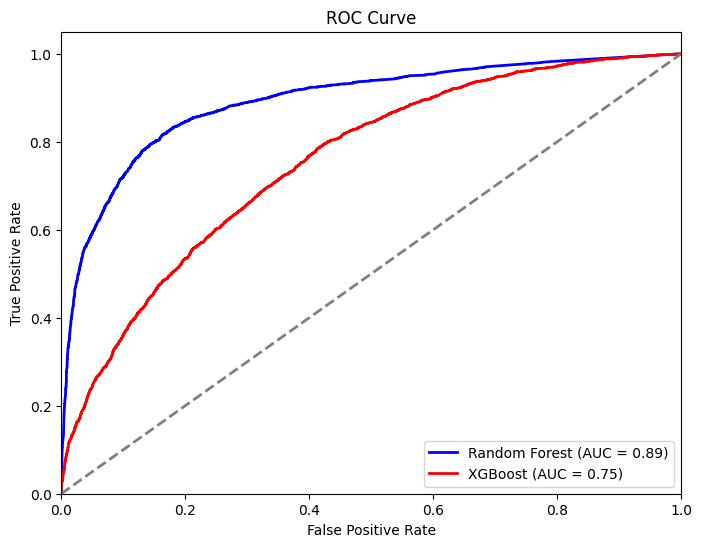

In [ ]:
'''T9. Plot ROC-curve.'''

from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Predict probabilities for each model
rf_probs = model_bag.predict_proba(X_test)[:, 1]
xgb_probs = model_boost.predict_proba(X_test)[:, 1]

# Calculate ROC curves and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)

xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', lw=2, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='red', lw=2, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#In this code:

#We create a sample DataFrame with features and a binary classification target.
#We split the data into training and testing sets.
#We train a Random Forest model and an XGBoost model.
#We calculate the ROC curve and AUC for both models.
#We plot the ROC curves and show the AUC values in the legend.
#You can adapt this code to your specific dataset and models. Make sure to replace the sample data with your actual data and modify the model parameters as needed.

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`.

In [ ]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# Predict on the validation data
y_pred = model_boost.predict(X_val)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)
model_cr = classification_report(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", model_cr)
print(model_cr)

Accuracy: 0.6984834968777877
Confusion Matrix:
 [[6832  260]
 [2782  215]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.96      0.82      7092
           1       0.45      0.07      0.12      2997

    accuracy                           0.70     10089
   macro avg       0.58      0.52      0.47     10089
weighted avg       0.63      0.70      0.61     10089

              precision    recall  f1-score   support

           0       0.71      0.96      0.82      7092
           1       0.45      0.07      0.12      2997

    accuracy                           0.70     10089
   macro avg       0.58      0.52      0.47     10089
weighted avg       0.63      0.70      0.61     10089



**Task 10 Testing**

In [ ]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [ ]:
'''T11. Create DataFrame of permutation importances.'''

from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

# Calculate accuracy on the validation data
y_pred = model_boost.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

# Calculate permutation importances
perm_importance = permutation_importance(model_boost, X_val, y_val, n_repeats=30, random_state=42)

# Create a DataFrame to store the importances
permutation_importances = pd.DataFrame({
    'Feature': X_val.columns,
    'Permutation_Importance': perm_importance.importances_mean,
    'Permutation_Importance_STD': perm_importance.importances_std
})

# Sort the DataFrame by importance (descending)
#permutation_importances = importance_df.sort_values(by='Permutation_Importance', ascending=False)

# Display the DataFrame
#permutation_importances

In [ ]:
permutation_importances.set_index('Feature', inplace=True)

In [ ]:
permutation_importances.head(10)

#permutation_importances.shape

,Permutation_Importance,Permutation_Importance_STD
Feature,,
Risk,-0.000691,0.000824
Latitude,0.007120,0.001646
Longitude,0.005323,0.001936
Inspection Type,0.006879,0.001889
Zip,0.001827,0.001517
Facility Type,0.001906,0.001085
City,-0.000099,0.000085


**Task 11 Testing**

In [ ]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)